# Generating new images with Variational Autoencoders

In this example we'll implement Variational Autoencoder (VAE) for generating new MNIST images using Tensorflow 2.0/Keras.

_This example is partially based on_ [https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py](https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py)


We'll start with the imports:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from matplotlib.markers import MarkerStyle
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import Model

Let's continue by instantiating the training and validation MNIST dataset using `tf.keras.datasets.mnist`:

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

image_size = x_train.shape[1] * x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size])
x_test = np.reshape(x_test, [-1, image_size])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

Next, we'll implement the `build_vae` function, which builds the VAE encoder, decoder, as well as the combination of the two. Note that the size of the latent vector `latent_dim` is 2. Later, this will help us visualize the VAE inner workings using 2D plots:

In [3]:
def build_vae(intermediate_dim=512, latent_dim=2):
    """
    Build VAE
    :param intermediate_dim: size of hidden layers of the encoder/decoder
    :param latent_dim: latent space size
    :returns tuple: the encoder, the decoder, and the full vae
    """

    # encoder first
    inputs = Input(shape=(image_size,), name='encoder_input')
    x = Dense(intermediate_dim, activation='relu')(inputs)

    # latent mean and variance
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # Reparameterization trick for random sampling
    # Note the use of the Lambda layer
    # At runtime, it will call the sampling function
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    # full encoder encoder model
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()

    # decoder
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(intermediate_dim, activation='relu')(latent_inputs)
    outputs = Dense(image_size, activation='sigmoid')(x)

    # full decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')
    decoder.summary()

    # VAE model
    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs, name='vae')

    # Loss function
    # we start wit the reconstruction loss
    reconstruction_loss = binary_crossentropy(inputs, outputs) * image_size

    # next is the KL divergence
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
    kl_loss *= -0.5

    # we combine them in a total loss
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)

    return encoder, decoder, vae

Then, we'll define the `sampling` routine, which implements the reparametrization trick. `sampling` is embedded directly in the Keras network graph as an operation: 

In [4]:
def sampling(args: tuple):
    """
    Reparameterization trick by sampling z from unit Gaussian
    :param args: (tensor, tensor) mean and log of variance of q(z|x)
    :returns tensor: sampled latent vector z
    """

    # unpack the input tuple
    z_mean, z_log_var = args

    # mini-batch size
    mb_size = K.shape(z_mean)[0]

    # latent space size
    dim = K.int_shape(z_mean)[1]

    # random normal vector with mean=0 and std=1.0
    epsilon = K.random_normal(shape=(mb_size, dim))

    return z_mean + K.exp(0.5 * z_log_var) * epsilon

Next, we'll implement the `plot_latent_distribution` function, which uses the encoder to plot the relationship the images of the test set and the 2 cells of the latent vector:

In [15]:
def plot_latent_distribution(encoder,
                             x_test,
                             y_test,
                             batch_size=128):
    """
    Display a 2D plot of the digit classes in the latent space.
    We are interested only in z, so we only need the encoder here.
    :param encoder: the encoder network
    :param x_test: test images
    :param y_test: test labels
    :param batch_size: size of the mini-batch
    """
    z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(12, 12))

    markers = ('o', 'x', '^', '<', '>', '*', 'h', 'H', 'D', 'd', 'P', 'X', '8', 's', 'p')

    for i in np.unique(y_test):
        plt.scatter(z_mean[y_test == i, 0], z_mean[y_test == i, 1],
                    marker=MarkerStyle(markers[i], fillstyle='none'),
                    edgecolors='black')

    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

We'll continue with another visualization, `plot_generated_images`, which will create a grid of newly generated decoder images, given certain distribution of the 2 cells of the latent vector. The _x,y_ grid coordinates reflect the values of the 2 cells of the latent vector:

In [13]:
def plot_generated_images(decoder):
    """
    Display a 2D plot of the generated images.
    We only need the decoder, because we'll manually sample the distribution z
    :param decoder: the decoder network
    """

    # display a nxn 2D manifold of digits
    n = 15
    digit_size = 28

    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    # start sampling z1 and z2 in the ranges grid_x and grid_y
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            slice_i = slice(i * digit_size, (i + 1) * digit_size)
            slice_j = slice(j * digit_size, (j + 1) * digit_size)
            figure[slice_i, slice_j] = digit

    # plot the results
    plt.figure(figsize=(15, 12))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

Next, we can put it all together, starting by instantiating the VAE model:

In [7]:
encoder, decoder, vae = build_vae()

vae.compile(optimizer='adam')
vae.summary()

W1208 00:13:04.780528 140314470709056 training_utils.py:1348] Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense[0][0]                      
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense[0][0]                      
____________________________________________________________________________________________

Then, we'll run the training:

In [8]:
vae.fit(x_train,
        epochs=50,
        batch_size=128,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 6s 106us/sample - loss: 195.1059 - val_loss: 171.1189
Epoch 2/50
60000/60000 [==============================] - 5s 89us/sample - loss: 168.8949 - val_loss: 167.2118
Epoch 3/50
60000/60000 [==============================] - 5s 90us/sample - loss: 165.8008 - val_loss: 165.1082
Epoch 4/50
60000/60000 [==============================] - 6s 93us/sample - loss: 163.7065 - val_loss: 163.0967
Epoch 5/50
60000/60000 [==============================] - 5s 89us/sample - loss: 161.7976 - val_loss: 161.3992
Epoch 6/50
60000/60000 [==============================] - 5s 89us/sample - loss: 160.0826 - val_loss: 159.6558
Epoch 7/50
60000/60000 [==============================] - 5s 90us/sample - loss: 158.7465 - val_loss: 158.4317
Epoch 8/50
60000/60000 [==============================] - 5s 91us/sample - loss: 157.7055 - val_loss: 157.7522
Epoch 9/50
60000/60000 [==============================] - 5s 

We can see the results of the training by first plotting the latent distribution of the test images, produced by the decoder:

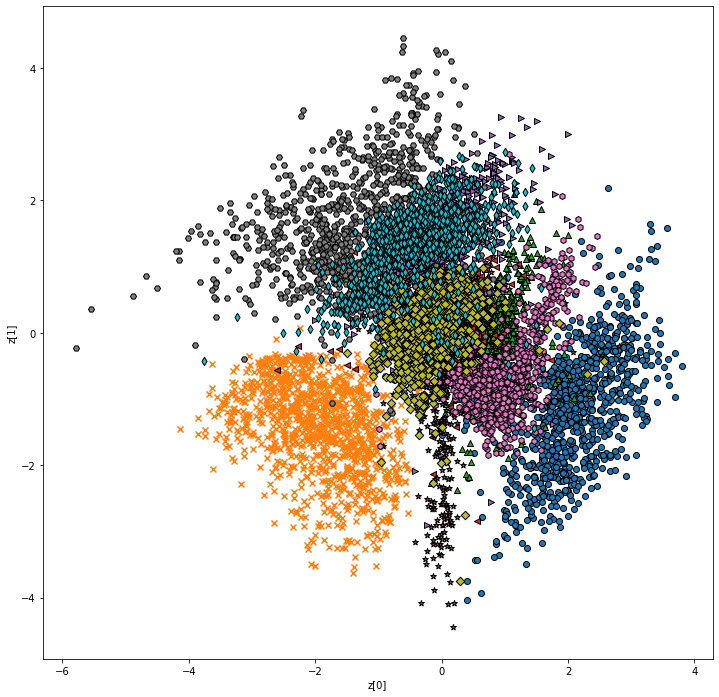

In [16]:
plot_latent_distribution(encoder,
                         x_test,
                         y_test,
                         batch_size=128)

Finally, let's see a set of newly generated decoder images:

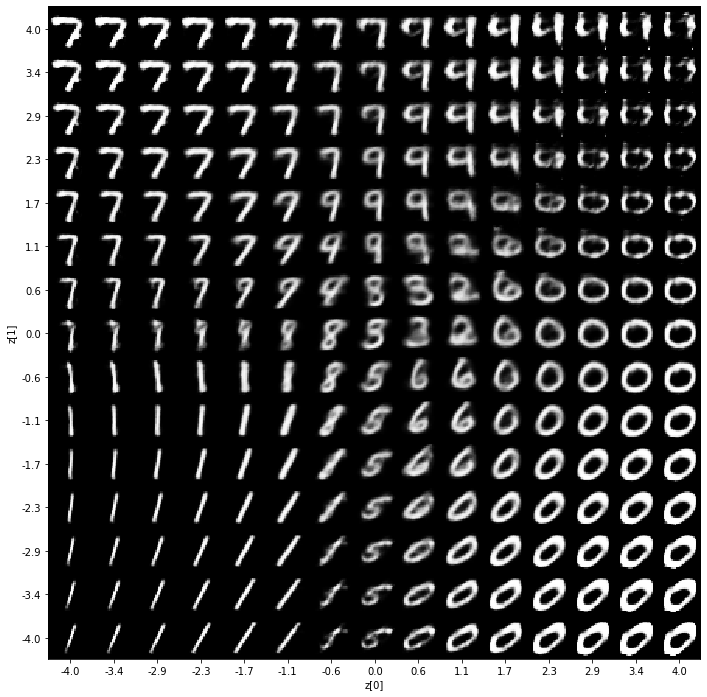

In [17]:
plot_generated_images(decoder)